In [1]:
# Purpose: Split the BioFairNet pilot dataset into train/test sets and save inputs/targets

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib  # for saving models

## Get the processed data

In [6]:
train_dir = "../data/processed/Train"
test_dir = "../data/processed/Test"

X_train = pd.read_csv(os.path.join(train_dir, "BioFairNet_Pilot1_Testrun_Train_in.csv"))
y_train = pd.read_csv(os.path.join(train_dir, "BioFairNet_Pilot1_Testrun_Train_out.csv"))
X_test = pd.read_csv(os.path.join(test_dir, "BioFairNet_Pilot1_Testrun_Test_in.csv"))
y_test = pd.read_csv(os.path.join(test_dir, "BioFairNet_Pilot1_Testrun_Test_out.csv"))


In [7]:
y_train_flatten = y_train['Pressure (bar)']
y_train_flatten.head(2)

0    37.9
1    39.1
Name: Pressure (bar), dtype: float64

In [8]:
models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {
            "fit_intercept": [True, False]
            #"normalize": [False]  # normalize deprecated in latest sklearn, ignored
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    }
}

In [9]:
y_train_final=y_train_flatten.to_numpy().ravel()

In [10]:
results = {}
best_models = {}

for name, model_info in models.items():
    print(f'Training {name}...')
    grid = GridSearchCV(model_info['model'],model_info['params'], cv=5, scoring='neg_root_mean_squared_error',n_jobs=-1)
    grid.fit(X_train,y_train_final)
    results[name] = {
        "best_score": -grid.best_score_,
        "best_params": grid.best_params_
    }
    best_models[name] = grid.best_estimator_

Training LinearRegression...
Training RandomForest...
Training GradientBoosting...


In [11]:
best_models

{'LinearRegression': LinearRegression(),
 'RandomForest': RandomForestRegressor(random_state=42),
 'GradientBoosting': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)}

In [12]:
best_models['LinearRegression'].predict(X_train)

array([37.30128608, 39.30452274, 23.38038788, ..., 39.0763123 ,
       11.42072698, 40.10497707], shape=(7380,))

In [13]:
best_models['RandomForest'].predict(X_train)

array([37.9  , 39.1  , 18.106, ..., 38.8  ,  7.313, 39.799], shape=(7380,))

In [14]:
results

{'LinearRegression': {'best_score': np.float64(1.8948237821887208),
  'best_params': {'fit_intercept': True}},
 'RandomForest': {'best_score': np.float64(0.02236662308381961),
  'best_params': {'max_depth': None,
   'min_samples_split': 2,
   'n_estimators': 100}},
 'GradientBoosting': {'best_score': np.float64(0.029444870905003202),
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}}}

# Evaluation and Comparison 📊

In [23]:
os.makedirs("../data/results", exist_ok=True)

In [15]:
y_test_final = y_test['Pressure (bar)'].to_numpy().ravel()

In [16]:
y_test_final = y_test_final.astype(float)

In [17]:
#Predictions
y_pred_lr = best_models['LinearRegression'].predict(X_test)
y_pred_rf = best_models['GradientBoosting'].predict(X_test)
y_pred_svr = best_models['RandomForest'].predict(X_test)

In [18]:
#metrics
rmse = [
    mean_squared_error(y_test, y_pred_lr),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_svr),
]

r2 = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_svr),
]

In [19]:
print(rmse)

[3.755055341042983, 0.0008026009064611175, 0.00047911761517612406]


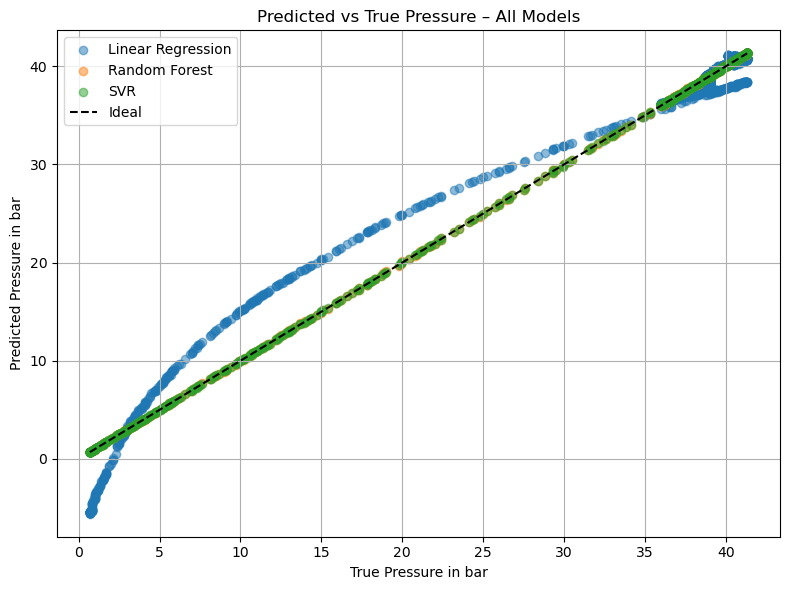

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_lr, label="Linear Regression", alpha=0.5)
plt.scatter(y_test, y_pred_rf, label="Random Forest", alpha=0.5)
plt.scatter(y_test, y_pred_svr, label="Gradient Boosting", alpha=0.5)

# Ideal line
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'k--', label='Ideal')

plt.xlabel("True Pressure in bar")
plt.ylabel("Predicted Pressure in bar")
plt.title("Predicted vs True Pressure – All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/results/lr_predictions_plot.png", dpi=800)

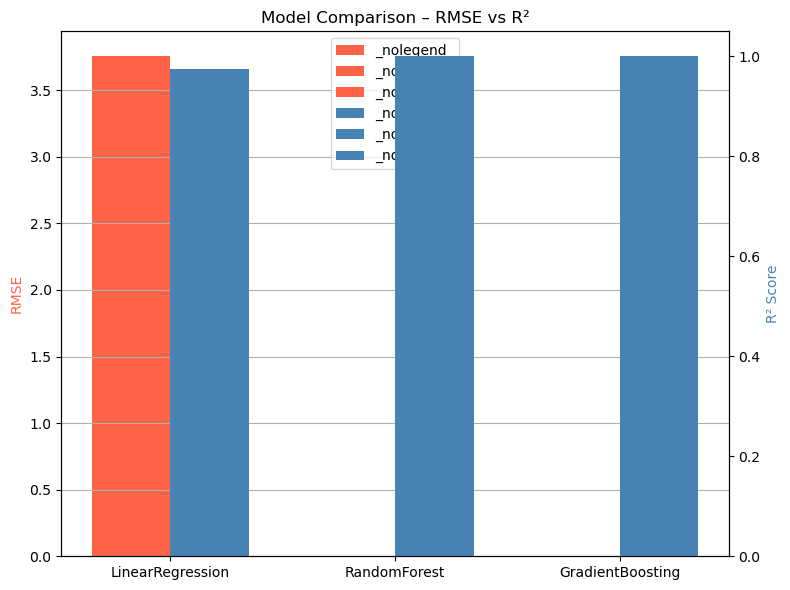

In [162]:
# Bar chart
x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 6))

# RMSE bars
bar1 = ax1.bar(x - width/2, rmse, width, label='RMSE', color='tomato')

# Create a second y-axis for R²
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, r2, width, label='R²', color='steelblue')

# Labels & legends
ax1.set_ylabel('RMSE', color='tomato')
ax2.set_ylabel('R² Score', color='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title("Model Comparison – RMSE vs R²")
ax1.grid(True, axis='y')

# Combined legend
bars = bar1 + bar2
labels = [b.get_label() for b in bars]
#ax1.legend(bars, labels, loc='upper center')

plt.tight_layout()
plt.show()

# Save Results, figure and prepare for upload to Zenodo 📁

In [29]:
pd.Series(results).to_csv("../data/results/lr_evaluation.csv")
Taskname = ("Testrun_Pilot1")
os.makedirs(f"../models{Taskname}/", exist_ok=True)

In [34]:
from pathlib import Path

In [36]:
repo_root = Path.cwd()
models_dir = repo_root / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Example: dict of models
all_models = {
    "linear_regression": best_models['LinearRegression'],
    "gradient_boosting": best_models['GradientBoosting'],
    "random_forest": best_models['RandomForest']
}

# Save the whole dict
all_models_path = models_dir / f"all_models{Taskname}.pkl"
joblib.dump(all_models, all_models_path)

print(f"✅ Saved all models to {all_models_path}")

✅ Saved all models to /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/notebooks/models/all_modelsTestrun_Pilot1.pkl


loaded_models = joblib.load("models/all_models.pkl")
print(loaded_models.keys())  # ['linear_regression', 'random_forest', 'xgboost']